# Objective:
Predict poverty on a household level
The Target values represent poverty levels as follows:

1 = extreme poverty

2 = moderate poverty 

3 = vulnerable households

4 = non vulnerable households

## About data provided:

     Here we are provided with a modelling data of 9557 rows and 143 features which consists of various factors that effects the household poverty level in some way.
     One row of information tells about one person
     Data consists of living situation,dependency of an individual,education,age etc
     Below is the list of the features with there name and description

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import statsmodels.api as sm
import scipy.stats as st

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier 

from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score


In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

In [3]:
family=pd.read_excel('costa_rican_modelling.xlsx')

In [4]:
family.drop(columns='Unnamed: 0',inplace=True)

# Feature Selection

As we have many features in our dataset which might lead us to curse of dimensionality, feature selection is done to reduce the no of features which are most required by filtering out less important features and removing them. 

There are few featurs in our dataset which are squared of other features. These features are generally added to increase the linearity of the model. Lets remove those set of the features as we are going with non-linear models.

In [5]:
#manually listed out the sqaured features.
squared = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
        'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq']

In [6]:
family_clean=family.drop(columns=squared)

In [7]:
#Derives pairs which have very high correlation.
corr_matrix = family_clean.corr().abs()
high_corr_var=np.where(corr_matrix>0.9)
high_corr_var=[(corr_matrix.columns[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]

In [8]:
high_corr_var

[('r4t3', 'tamhog'),
 ('r4t3', 'tamviv'),
 ('r4t3', 'hhsize'),
 ('r4t3', 'hogar_total'),
 ('tamhog', 'tamviv'),
 ('tamhog', 'hhsize'),
 ('tamhog', 'hogar_total'),
 ('tamviv', 'hhsize'),
 ('tamviv', 'hogar_total'),
 ('hhsize', 'hogar_total'),
 ('abastaguadentro', 'abastaguafuera'),
 ('public', 'coopele'),
 ('sanitario2', 'sanitario3'),
 ('energcocinar2', 'energcocinar3'),
 ('male', 'female'),
 ('area1', 'area2')]

The above pairs have high correlation, and by the feature description we can also notice that few of these features explain the same thing (redundancy in the data).

- r4t3,tamhog,tamviv,hhsize,hogar_total give information of about total no of people in the household, thus this is a redundant information, hence only one of these features can be selected.
- pairs such as ('male', 'female'),('area1', 'area2'),('abastaguadentro', 'abastaguafuera'),('public', 'coopele') are boolean type features which contradict each other, hence only one of the features in these pairs can be selected.
- Other two pairs left, give us different information but are highly correlated. We will keep these features for now and apply any feature selection method to reduce features further.

features to remove are:

- r4t3
- tamhog 
- tamviv
- hogar_total
- female
- area2
- abastaguafuera
- coopele

In [9]:
redundant=['r4t3','tamhog','tamviv','hogar_total','female','area2','abastaguafuera','coopele']

In [10]:
family_clean.drop(columns=redundant,inplace=True)

# MODEL BUILDING

In [11]:
family_clean.isnull().sum()

hacdor    0
rooms     0
hacapo    0
v14a      0
refrig    0
         ..
lugar5    0
lugar6    0
area1     0
age       0
Target    0
Length: 122, dtype: int64

Before we go into modelling there are few considerations that we have made, which are:

- As our data is imbalanced, undersampling and oversampling will be performed and models accuracies will be compared accordingly
- A model which can predict all the classes better would be considered apart from the acuracies.
- As explainability is one of the objectives here, apart from prediction,dimensionality reduction techniques will be mostly avoided along with models which focuses mainly on performance.

In [12]:
from numpy import mean
from sklearn.datasets import make_classification

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

In [13]:
x=family_clean.drop(columns=['Target','idhogar'])
y=family_clean.Target

In [14]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.3,random_state=100)

In [15]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

In [16]:
xtrain_scale=pd.DataFrame(scaler.fit_transform(xtrain),columns=xtrain.columns)
xtest_scale=pd.DataFrame(scaler.fit_transform(xtest),columns=xtest.columns)

In [17]:
ytrain.value_counts()

4    4194
2    1105
3     873
1     517
Name: Target, dtype: int64

In [18]:
nm=NearMiss()

In [19]:
xtrain_nm, ytrain_nm = nm.fit_resample(xtrain, ytrain)

In [20]:
ytrain_nm.value_counts()

3    517
1    517
4    517
2    517
Name: Target, dtype: int64

In [21]:
sm=SMOTE()

In [22]:
xtrain_sm, ytrain_sm = sm.fit_resample(xtrain, ytrain)

In [23]:
ytrain_sm.value_counts()

4    4194
3    4194
2    4194
1    4194
Name: Target, dtype: int64

In [24]:
#createing a list of models to perform a loop on different training sets and select a model.
DT1= DecisionTreeClassifier(criterion = 'entropy',random_state=0 )
DT2= DecisionTreeClassifier(criterion = 'gini',random_state=0 )
KNN= KNeighborsClassifier(metric='manhattan')

models2=[]
models2.append(('DecisionTree_entropy',DT1))
models2.append(('DecisionTree_gini',DT2))
models2.append(('KNN',KNN))


DecisionTree_entropy: 0.104185 (0.000097)
DecisionTree_gini: 0.113916 (0.000067)
KNN: 0.206183 (0.000206)


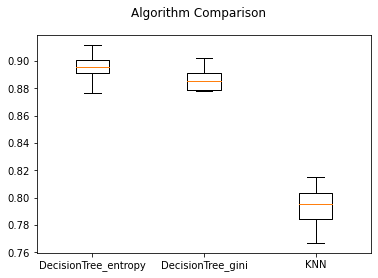

In [25]:
from sklearn import model_selection

# evaluate each model in turn
results2 = []
names2 = []
for name, model in models2:
	kfold = model_selection.KFold(shuffle=True,n_splits=10,random_state=0)
	cv_results = model_selection.cross_val_score(model, xtrain_scale, ytrain,cv=kfold, scoring='f1_weighted')
	results2.append(cv_results)
	names2.append(name)
	print("%s: %f (%f)" % (name, 1-np.mean(cv_results),np.var(cv_results,ddof=1)))
   # boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results2)
ax.set_xticklabels(names2)
plt.show()


DecisionTree_entropy: 0.104006 (0.000109)
DecisionTree_gini: 0.113739 (0.000064)
KNN: 0.320886 (0.000431)


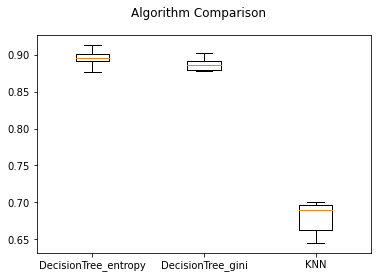

In [26]:
from sklearn import model_selection

# evaluate each model in turn
results2 = []
names2 = []
for name, model in models2:
	kfold = model_selection.KFold(shuffle=True,n_splits=10,random_state=0)
	cv_results = model_selection.cross_val_score(model, xtrain, ytrain,cv=kfold, scoring='f1_weighted')
	results2.append(cv_results)
	names2.append(name)
	print("%s: %f (%f)" % (name, 1-np.mean(cv_results),np.var(cv_results,ddof=1)))
   # boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results2)
ax.set_xticklabels(names2)
plt.show()


DecisionTree_entropy: 0.306569 (0.000609)
DecisionTree_gini: 0.303697 (0.001388)
KNN: 0.521252 (0.001509)


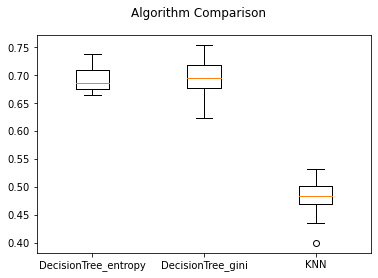

In [27]:
from sklearn import model_selection

# evaluate each model in turn
results2 = []
names2 = []
for name, model in models2:
	kfold = model_selection.KFold(shuffle=True,n_splits=10,random_state=0)
	cv_results = model_selection.cross_val_score(model, xtrain_nm, ytrain_nm,cv=kfold, scoring='f1_weighted')
	results2.append(cv_results)
	names2.append(name)
	print("%s: %f (%f)" % (name, 1-np.mean(cv_results),np.var(cv_results,ddof=1)))
   # boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results2)
ax.set_xticklabels(names2)
plt.show()


DecisionTree_entropy: 0.115113 (0.000108)
DecisionTree_gini: 0.122498 (0.000089)
KNN: 0.117373 (0.000115)


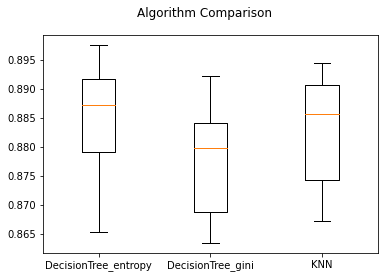

In [28]:
from sklearn import model_selection

# evaluate each model in turn
results2 = []
names2 = []
for name, model in models2:
	kfold = model_selection.KFold(shuffle=True,n_splits=10,random_state=0)
	cv_results = model_selection.cross_val_score(model, xtrain_sm, ytrain_sm,cv=kfold, scoring='f1_weighted')
	results2.append(cv_results)
	names2.append(name)
	print("%s: %f (%f)" % (name, 1-np.mean(cv_results),np.var(cv_results,ddof=1)))
   # boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results2)
ax.set_xticklabels(names2)
plt.show()


From the above boxplot comparisions of the base models with different training sets, following inferences can be derived:

- DT with entropy performs well in all cases, RF can be adopted over here.
- scaling the data can be avoided as KNN is not the choice over here.
- undersampled data is not enough for the model to learn the pattern and make accurate predictions.
- Although imbalance data and oversampled data gives us better scores, its ability to predict all classes needs to checked.

# Random Forest

In [29]:
RF_whole=RandomForestClassifier()

In [30]:
#lets use Grid Search CV to find best params for the model
param_dist = {'n_estimators':range(25,100),'max_depth':[20,23],'bootstrap': [True, False],'criterion':['entropy']}

RFCV= GridSearchCV(RF_whole, cv = 10,param_grid=param_dist, n_jobs = 3)

RFCV.fit(xtrain,ytrain)
print('Best Parameters using grid search: \n', RFCV.best_params_)  

Best Parameters using grid search: 
 {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 23, 'n_estimators': 61}


In [31]:
RF_whole=RandomForestClassifier(bootstrap=False, criterion= 'entropy', max_depth= 23, n_estimators= 61)

In [32]:
#cross_val_training score

#using imbalance data only as it gives highest accuracy.
kfold=KFold(shuffle=True,n_splits=10,random_state=0)
scores=cross_val_score(RF_whole,xtrain,ytrain,cv=kfold,scoring='f1_weighted')

In [33]:
print(scores.mean())
print(scores.var())

0.929260445402031
0.00010460971491078593


In [34]:
RF_whole.fit(xtrain,ytrain)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=23,
                       n_estimators=61)

In [35]:
whole_pred=RF_whole.predict(xtest)
print(classification_report(ytest,whole_pred))
print()
print(confusion_matrix(ytest,whole_pred)) 

              precision    recall  f1-score   support

           1       0.93      0.83      0.88       238
           2       0.92      0.85      0.88       492
           3       0.94      0.85      0.89       336
           4       0.95      0.99      0.97      1802

    accuracy                           0.94      2868
   macro avg       0.93      0.88      0.91      2868
weighted avg       0.94      0.94      0.94      2868


[[ 198   16    1   23]
 [  15  420   10   47]
 [   0   18  286   32]
 [   1    5    8 1788]]


- As we can observe we have very good accuracies for all the classes, Hence we can consider our final model to be performing very well.
- Although we did try treating the imbalance in the data, results from the imbalance data have feteched us best results.
- Lets now have a look at what features have contributed the most to the prediction.

In [37]:
#we are taking only top 10 features.
features_significance=pd.DataFrame(RF_whole.feature_importances_)

In [43]:
features_significance.index=xtrain.columns

In [52]:
features_significance.sort_values(by=0,ascending=False).iloc[0:10]

,0
meaneduc,0.068946
dependency,0.047830
overcrowding,0.039139
edjefe,0.036575
hogar_nin,0.032444
qmobilephone,0.032185
rooms,0.027359
r4t2,0.024036
edjefa,0.024006
hhsize,0.023864


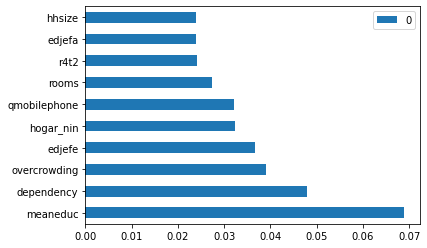

In [54]:
features_significance.sort_values(by=0,ascending=False).iloc[0:10].plot(kind='barh')